In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
import json

import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [3]:
df = pd.read_csv("/Users/ruoyu/Desktop/22 Fall/INLS 690/Individual Project/COVID-19 Literature Clustering Processed Data.csv")
df.head()

,paper_id,doi,abstract,body_text,authors,title,journal,abstract_summary,abstract_word_count,body_word_count,body_unique_words,language
0,4fcb95cc0c4ea6d1fa4137a4a087715ed6b68cea,10.1007/s00431-019-03543-0,Abnormal levels of end-tidal carbon dioxide (E...,Improvements in neonatal intensive care have r...,"Tamura, Kentaro. Williams, Emma E. Dassios,...",End-tidal carbon dioxide levels during resusc...,Eur J Pediatr,Abnormal levels of end-tidal carbon dioxide (...,218,2601,830,en
1,86d4262de73cf81b5ea6aafb91630853248bff5f,10.1016/j.bbamcr.2011.06.011,The endoplasmic reticulum (ER) is the biggest ...,The endoplasmic reticulum (ER) is a multi-func...,"Lynes, Emily M.. Simmen, Thomas",Urban planning of the endoplasmic reticulum (...,Biochimica et Biophysica Acta (BBA) - Molecula...,The endoplasmic reticulum (ER) is the biggest...,234,8069,2282,en
2,306ef95a3a91e13a93bcc37fb2c509b67c0b5640,10.1093/cid/ciaa256,Thousands of people in the United States have ...,"The 2019 novel coronavirus (SARS-CoV-2), ident...","Bryson-Cahn, Chloe. Duchin, Jeffrey. Makare...",A Novel Approach for a Novel Pathogen: using ...,Clin Infect Dis,Thousands of people in the United States have...,50,944,486,en
3,6599ebbef3d868afac9daa4f80fa075675cf03bc,10.1016/j.enpol.2008.08.029,"International aviation is growing rapidly, res...","Sixty years ago, civil aviation was an infant ...","Macintosh, Andrew. Wallace, Lailey",International aviation emissions to 2025: Can...,Energy Policy,"International aviation is growing rapidly, re...",140,5838,1587,en
4,ad98979eada6e333a276d39efdce21779d538625,10.1177/2040206618813050,While noncanonic xanthine nucleotides XMP/dXMP...,The concentration and ratio of purine nucleoti...,"Baszczyňski, Ondřej. Kaiser, Martin Maxmilia...",Xanthine-based acyclic nucleoside phosphonate...,Antivir Chem Chemother,While noncanonic xanthine nucleotides XMP/dXM...,192,3049,1237,en


# Drop Body Text Column
I decided to only use abstract in this project to reduce the computational time and effort. Therefore, body text will be dropped from this dataset

In [4]:
df = df.drop(['body_text'], axis = 1, errors = 'ignore')
len(df)

32260

# Randomly sampel 5000 literatures

In [5]:
df = df.sample(n=5000)
len(df)

5000

In [5]:
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.4/en_core_sci_lg-0.2.4.tar.gz   

  Using cached https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.4/en_core_sci_lg-0.2.4.tar.gz (500.6 MB)
  Preparing metadata (setup.py) ... done

[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: pip install --upgrade pip


# Text Parsing

In [6]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_sci_lg
import string

/Users/ruoyu/opt/anaconda3/lib/python3.8/site-packages/spacy/util.py:885: UserWarning: [W094] Model 'en_core_sci_lg' (0.2.4) specifies an under-constrained spaCy version requirement: >=2.2.1. This can lead to compatibility problems with older versions, or as new spaCy versions are released, because the model may say it's compatible when it's not. Consider changing the "spacy_version" in your meta.json to a version range, with a lower and upper pin. For example: >=3.4.3,<3.5.0
  warnings.warn(warn_msg)


In [7]:
punctuations = string.punctuation
stopwords = list(STOP_WORDS)
stopwords[:10]

['for',
 'we',
 'seemed',
 'i',
 'it',
 'indeed',
 'put',
 'himself',
 'whence',
 'twelve']

In [8]:
custom_stop_words = [
    'doi', 'preprint', 'copyright', 'peer', 'reviewed', 'org', 'https', 'et', 'al', 'author', 'figure', 
    'rights', 'reserved', 'permission', 'used', 'using', 'biorxiv', 'medrxiv', 'license', 'fig', 'fig.', 
    'al.', 'Elsevier', 'elsevier','PMC', 'CZI','czi', 'll', 'pmc', 've'
]

for w in custom_stop_words:
    if w not in stopwords:
        stopwords.append(w)

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
def vectorize(text, maxx_features):
    
    vectorizer = TfidfVectorizer(max_features=maxx_features, stop_words = stopwords)
    X = vectorizer.fit_transform(text)
    return X

In [10]:
text = df['abstract'].values
max_features = 2**12

X = vectorize(text, max_features)

# PCA

In [11]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95, random_state=27)
X_reduced= pca.fit_transform(X.toarray())
X_reduced.shape

(5000, 2358)

# K Mean Clustering

In [26]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans
from sklearn import metrics

# run kmeans with many different k
distortions = []
K = range(2, 40)
for k in K:
    k_means = KMeans(n_clusters=k, random_state=42, init='k-means++')
    k_means.fit(X_reduced)
    print(k_means.inertia_)
    distortions.append(k_means.inertia_)

4587.880062018215
4551.853997892501
4528.5527245468875
4510.778666974142
4492.83417092318
4479.12836647101
4464.972919421644
4454.760564553419
4442.289441646359
4429.513062151527
4416.986862216259
4405.71027558253
4392.777851703651
4382.904665250141
4375.738451119951
4368.684969621139
4358.680667211918
4353.966926094324
4343.535325935694
4337.228694983828
4326.526668269782
4318.847931126693
4314.343381679189
4308.291707191492
4303.610310275172
4295.1785095901905
4291.5198235849
4282.990069412426
4273.518342865432
4271.0231608648055
4265.286388174859
4256.934812764602
4252.746021969395
4251.616181073989
4238.89589097161
4235.594500666777
4234.39419090517
4230.048852992059


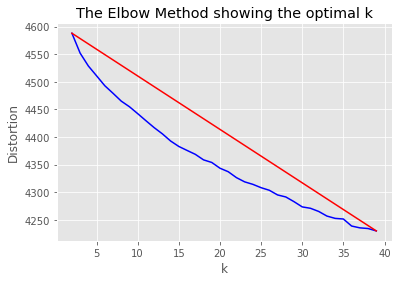

In [27]:
X_line = [K[0], K[-1]]
Y_line = [distortions[0], distortions[-1]]

# Plot the elbow
plt.plot(K, distortions, 'b-')
plt.plot(X_line, Y_line, 'r')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

The elbow methods is inconclusive

In [34]:
from sklearn.metrics import silhouette_score

sil = []
kmax = 30

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(2, kmax+1):
    kmeans = KMeans(n_clusters = k).fit(X_reduced)
    labels = kmeans.labels_
    print(silhouette_score(X_reduced, labels, metric = 'euclidean'))
    sil.append(silhouette_score(X_reduced, labels, metric = 'euclidean'))


0.004999552656802594
0.006162864384253841
0.007423174331286898
0.008661997749381988
0.00885418484223725
0.009159134966934438
0.010114745467067289
0.010283999737233058
0.009044132957188861
0.010368696841747465
0.01091154245975272
0.010766066523484602
0.01021785238310031
0.01088961913233752
0.011251678810041426
0.011929676642952003
0.013510620390988336
0.014292414782409472
0.01441652987442051
0.014335865600941093
0.014784844869144742
0.015677895068587504
0.01631634165389978
0.015867123317051507
0.01792115648804833
0.01623921434488275
0.01635698090972099
0.01743306753310735
0.016903807476345928


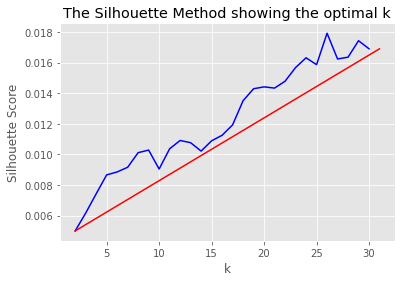

In [36]:
K = range(2, 31)
X_sil = [K[0], K[-1]+1]
Y_sil = [sil[0], sil[-1]]

# Plot the elbow
plt.plot(K, sil, 'b-')
plt.plot(X_sil, Y_sil, 'r')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('The Silhouette Method showing the optimal k')
plt.show()

The Silhouette method shows that the optimal K is 26

In [37]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans
from sklearn import metrics
k = 26
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X_reduced)
df['y'] = y_pred

# Dimensionality Reduction with t-SNE

In [38]:
from sklearn.manifold import TSNE

tsne = TSNE(verbose=1, perplexity=50)
X_embedded = tsne.fit_transform(X.toarray())

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.018s...
[t-SNE] Computed neighbors for 5000 samples in 2.034s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.468031
[t-SNE] KL divergence after 250 iterations with early exaggeration: 153.260544
[t-SNE] KL divergence after 1000 iterations: 3.661111


/Users/ruoyu/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


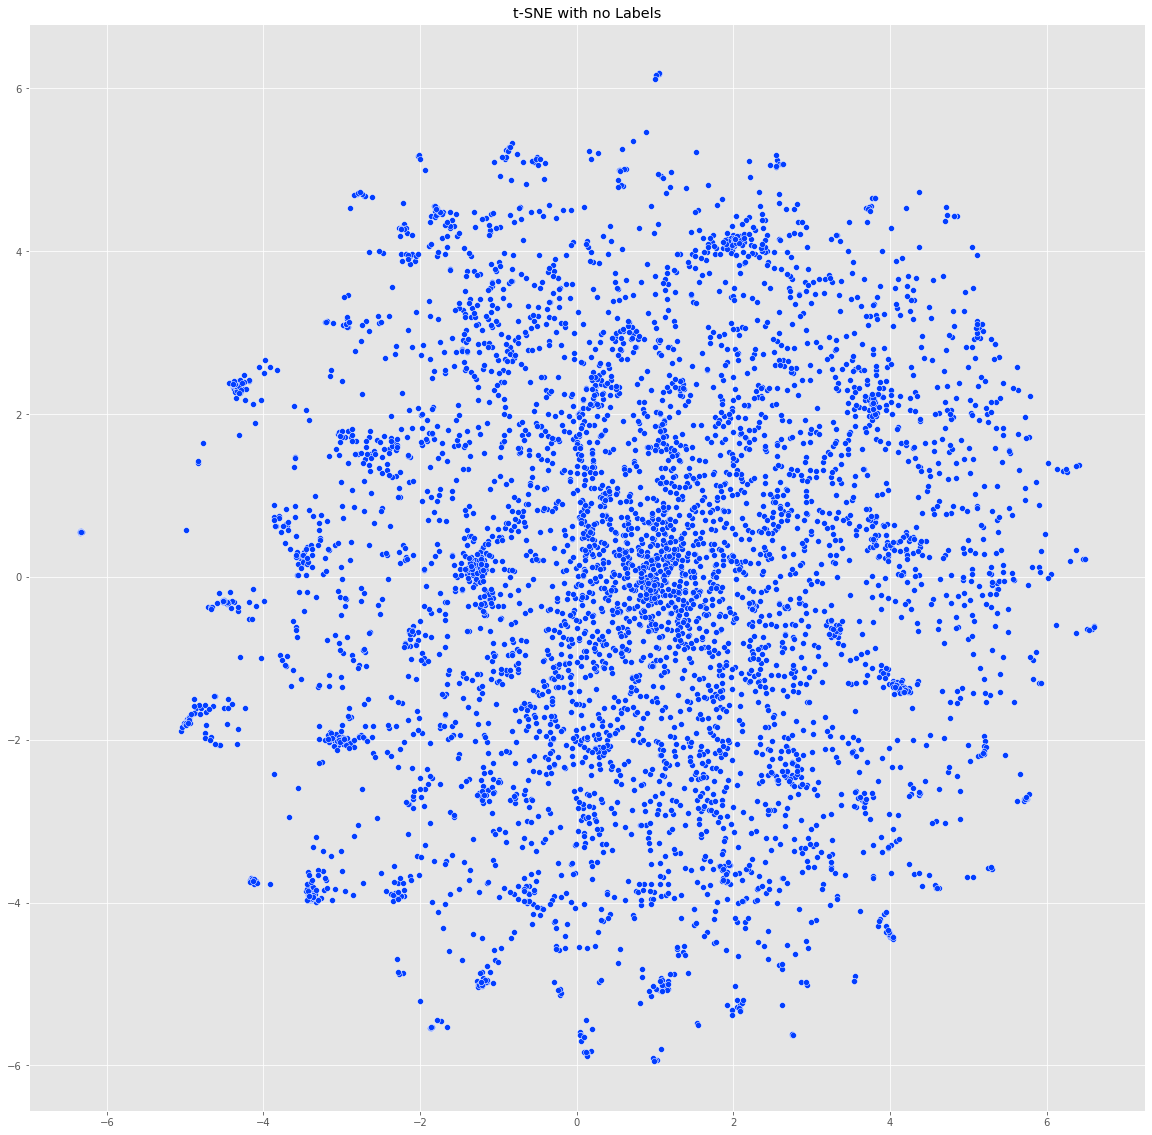

In [39]:
from matplotlib import pyplot as plt
import seaborn as sns

# colors
sns.set_palette("bright")
# size
plt.figure(figsize=(20,20))
# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1])
plt.title('t-SNE with no Labels')
plt.savefig("t-sne_covid19.png")
plt.show()

# Visualizing Clusters

/Users/ruoyu/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


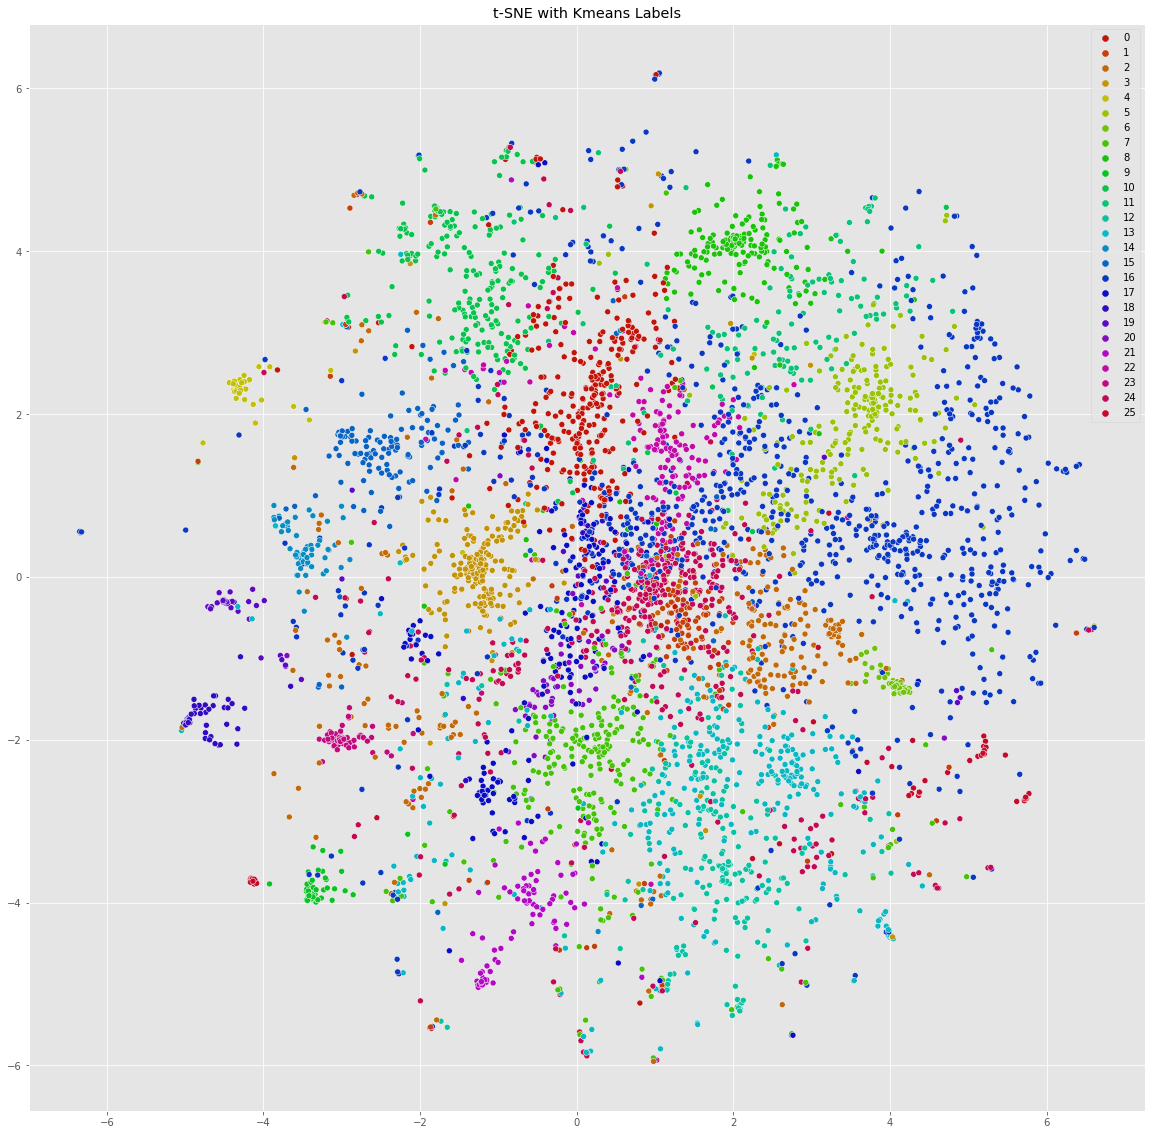

In [40]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

# size
plt.figure(figsize=(20,20))

# colors
palette = sns.hls_palette(26, l=.4, s=.9)

# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y_pred, legend='full', palette=palette)
plt.title('t-SNE with Kmeans Labels')
plt.savefig("improved_cluster_tsne.png")
plt.show()

# Topic Modeling

In [67]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import gensim
from gensim import corpora
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, STOPWORDS

In [55]:
def prepare_text_for_lda(text):
    # convert all words into lower case, split by white space
    tokens = text.strip().lower().split()
    
    #  remove words with 1 or 2 letters (small words, punctuation)
    tokens = [token for token in tokens if len(token) > 2]
    
    # remove English stopwords
    tokens = [token for token in tokens if token not in stopwords]
    return tokens

Number of topics: 1
(0, '0.019*"patients" + 0.005*"respiratory" + 0.004*"acute" + 0.004*"clinical" + 0.003*"risk" + 0.003*"associated" + 0.003*"study" + 0.003*"severe" + 0.003*"infection" + 0.003*"group" + 0.002*"patients." + 0.002*"days" + 0.002*"mortality" + 0.002*"treatment" + 0.002*"disease" + 0.002*"patient" + 0.002*"pneumonia" + 0.002*"cases" + 0.002*"rate" + 0.002*"95%"')


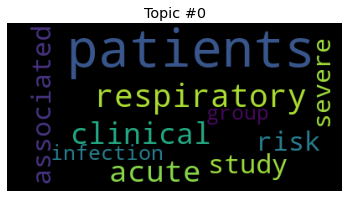

Number of topics: 1
(0, '0.009*"activity" + 0.008*"antiviral" + 0.006*"compounds" + 0.005*"virus" + 0.003*"viral" + 0.003*"human" + 0.003*"showed" + 0.002*"viruses" + 0.002*"new" + 0.002*"vitro" + 0.002*"potential" + 0.002*"activities" + 0.002*"active" + 0.002*"synthesized" + 0.002*"inhibition" + 0.002*"study" + 0.002*"compound" + 0.002*"cell" + 0.002*"results" + 0.002*"inhibited"')


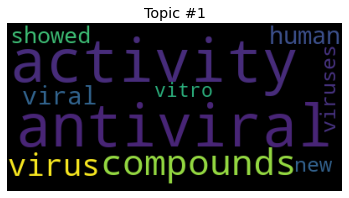

Number of topics: 1
(0, '0.006*"virus" + 0.006*"viral" + 0.006*"viruses" + 0.005*"species" + 0.005*"human" + 0.004*"gene" + 0.003*"sequences" + 0.003*"genome" + 0.003*"genes" + 0.003*"sequence" + 0.003*"analysis" + 0.003*"rna" + 0.002*"samples" + 0.002*"host" + 0.002*"novel" + 0.002*"new" + 0.002*"different" + 0.002*"genetic" + 0.002*"study" + 0.002*"disease"')


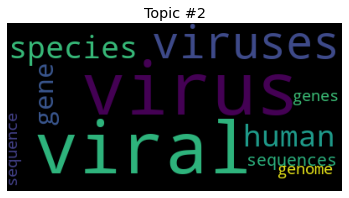

Number of topics: 1
(0, '0.008*"sars-cov" + 0.008*"sars" + 0.008*"sars-cov-2" + 0.006*"respiratory" + 0.005*"coronavirus" + 0.005*"protein" + 0.005*"viral" + 0.005*"severe" + 0.004*"acute" + 0.004*"human" + 0.004*"virus" + 0.004*"syndrome" + 0.004*"patients" + 0.003*"infection" + 0.003*"novel" + 0.003*"proteins" + 0.002*"spike" + 0.002*"cell" + 0.002*"host" + 0.002*"potential"')


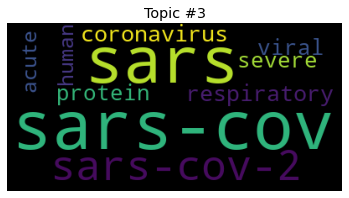

Number of topics: 1
(0, '0.023*"mers-cov" + 0.010*"respiratory" + 0.007*"middle" + 0.006*"syndrome" + 0.006*"east" + 0.006*"coronavirus" + 0.006*"mers" + 0.006*"infection" + 0.005*"virus" + 0.005*"human" + 0.004*"(mers-cov)" + 0.004*"cases" + 0.004*"protein" + 0.003*"camels" + 0.003*"infection." + 0.003*"clinical" + 0.003*"patients" + 0.003*"transmission" + 0.003*"disease" + 0.003*"spike"')


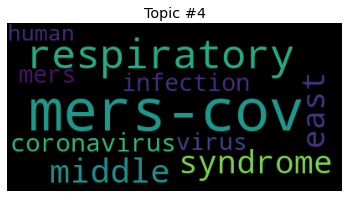

Number of topics: 1
(0, '0.019*"health" + 0.009*"public" + 0.006*"infectious" + 0.006*"disease" + 0.004*"diseases" + 0.004*"global" + 0.003*"emerging" + 0.003*"surveillance" + 0.003*"research" + 0.003*"control" + 0.003*"data" + 0.003*"information" + 0.002*"risk" + 0.002*"human" + 0.002*"outbreak" + 0.002*"study" + 0.002*"emergency" + 0.002*"social" + 0.002*"systems" + 0.002*"new"')


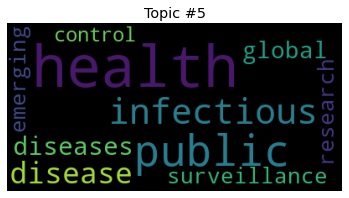

Number of topics: 1
(0, '0.021*"bat" + 0.014*"bats" + 0.006*"viruses" + 0.006*"species" + 0.006*"virus" + 0.003*"detected" + 0.003*"viral" + 0.003*"human" + 0.003*"study" + 0.003*"coronaviruses" + 0.003*"new" + 0.003*"samples" + 0.003*"different" + 0.003*"bats." + 0.003*"zoonotic" + 0.002*"novel" + 0.002*"identified" + 0.002*"phylogenetic" + 0.002*"found" + 0.002*"sequences"')


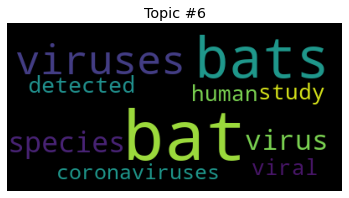

Number of topics: 1
(0, '0.016*"cells" + 0.012*"cell" + 0.005*"virus" + 0.004*"cells." + 0.004*"infection" + 0.004*"expression" + 0.003*"viral" + 0.003*"human" + 0.003*"cells," + 0.003*"protein" + 0.002*"immune" + 0.002*"infected" + 0.002*"role" + 0.002*"results" + 0.002*"found" + 0.002*"apoptosis" + 0.002*"receptor" + 0.002*"type" + 0.002*"infection." + 0.002*"activation"')


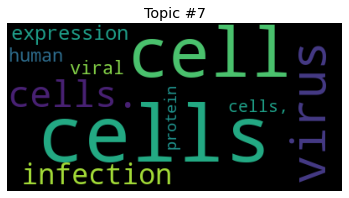

Number of topics: 1
(0, '0.017*"covid-19" + 0.008*"patients" + 0.005*"coronavirus" + 0.005*"disease" + 0.005*"cases" + 0.004*"clinical" + 0.004*"severe" + 0.004*"covid-19." + 0.003*"risk" + 0.003*"health" + 0.003*"pandemic" + 0.003*"respiratory" + 0.002*"data" + 0.002*"acute" + 0.002*"2019" + 0.002*"outbreak" + 0.002*"treatment" + 0.002*"novel" + 0.002*"infection" + 0.002*"new"')


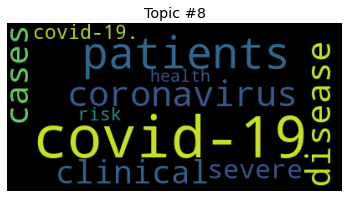

Number of topics: 1
(0, '0.026*"pedv" + 0.010*"virus" + 0.009*"porcine" + 0.008*"diarrhea" + 0.007*"epidemic" + 0.004*"(pedv)" + 0.004*"strain" + 0.004*"protein" + 0.003*"viral" + 0.003*"strains" + 0.003*"pigs" + 0.003*"piglets" + 0.003*"swine" + 0.003*"infection" + 0.003*"gene" + 0.003*"cell" + 0.003*"cells" + 0.003*"infected" + 0.003*"showed" + 0.002*"results"')


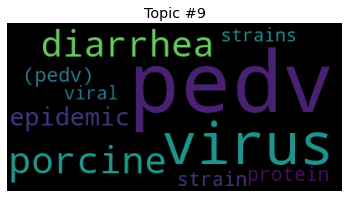

Number of topics: 1
(0, '0.022*"respiratory" + 0.011*"children" + 0.011*"viral" + 0.007*"infections" + 0.007*"viruses" + 0.007*"acute" + 0.007*"virus" + 0.006*"infection" + 0.006*"rsv" + 0.005*"patients" + 0.005*"study" + 0.005*"clinical" + 0.005*"human" + 0.004*"tract" + 0.004*"associated" + 0.003*"detected" + 0.003*"disease" + 0.003*"syncytial" + 0.003*"severe" + 0.003*"positive"')


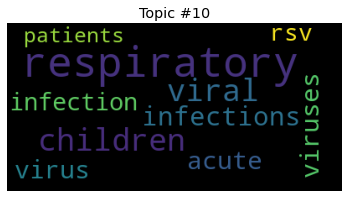

Number of topics: 1
(0, '0.009*"care" + 0.006*"health" + 0.004*"patients" + 0.003*"patient" + 0.003*"medical" + 0.003*"use" + 0.003*"hospitals" + 0.003*"infection" + 0.003*"hospital" + 0.003*"respiratory" + 0.002*"pandemic" + 0.002*"emergency" + 0.002*"surgical" + 0.002*"healthcare" + 0.002*"ppe" + 0.002*"disease" + 0.002*"control" + 0.002*"study" + 0.002*"management" + 0.002*"acute"')


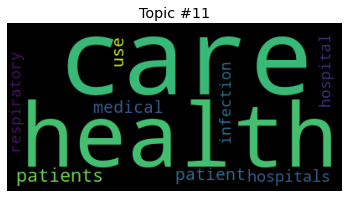

Number of topics: 1
(0, '0.012*"viral" + 0.010*"virus" + 0.007*"proteins" + 0.006*"protein" + 0.006*"host" + 0.005*"cell" + 0.005*"membrane" + 0.005*"entry" + 0.004*"cellular" + 0.004*"fusion" + 0.004*"viruses" + 0.004*"cells" + 0.004*"infection" + 0.004*"replication" + 0.003*"autophagy" + 0.002*"hcv" + 0.002*"role" + 0.002*"infection." + 0.002*"rna" + 0.002*"human"')


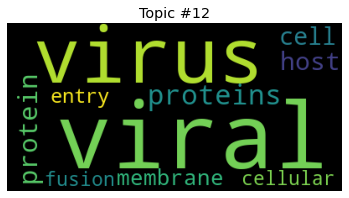

Number of topics: 1
(0, '0.011*"rna" + 0.011*"protein" + 0.007*"viral" + 0.006*"proteins" + 0.005*"virus" + 0.003*"expression" + 0.003*"sequence" + 0.003*"gene" + 0.003*"structure" + 0.002*"replication" + 0.002*"cellular" + 0.002*"binding" + 0.002*"viruses" + 0.002*"dna" + 0.002*"genome" + 0.002*"found" + 0.002*"structural" + 0.002*"cells" + 0.002*"human" + 0.002*"analysis"')


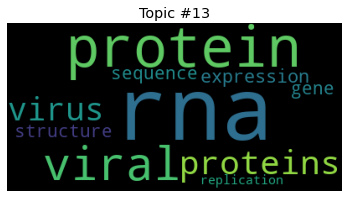

Number of topics: 1
(0, '0.015*"calves" + 0.006*"bovine" + 0.005*"respiratory" + 0.005*"diarrhea" + 0.004*"study" + 0.004*"virus" + 0.004*"calf" + 0.004*"treatment" + 0.003*"dairy" + 0.003*"samples" + 0.003*"bvdv" + 0.003*"calves." + 0.003*"disease" + 0.003*"days" + 0.003*"neonatal" + 0.003*"cattle" + 0.003*"cryptosporidium" + 0.003*"animals" + 0.002*"spp." + 0.002*"infected"')


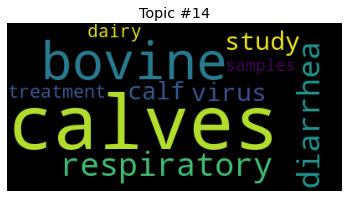

Number of topics: 1
(0, '0.013*"detection" + 0.010*"assay" + 0.006*"virus" + 0.006*"samples" + 0.005*"clinical" + 0.005*"pcr" + 0.005*"amplification" + 0.004*"real-time" + 0.004*"respiratory" + 0.004*"viral" + 0.004*"reaction" + 0.004*"positive" + 0.004*"rt-pcr" + 0.003*"viruses" + 0.003*"method" + 0.003*"results" + 0.003*"sensitivity" + 0.003*"assays" + 0.003*"diagnosis" + 0.003*"rna"')


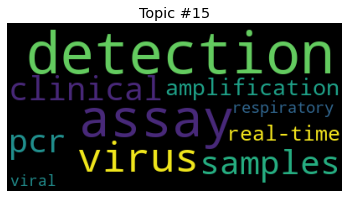

Number of topics: 1
(0, '0.003*"data" + 0.003*"disease" + 0.003*"study" + 0.003*"model" + 0.002*"results" + 0.002*"infection" + 0.002*"different" + 0.002*"analysis" + 0.002*"number" + 0.002*"based" + 0.002*"however," + 0.002*"virus" + 0.002*"transmission" + 0.002*"control" + 0.002*"infectious" + 0.001*"epidemic" + 0.001*"use" + 0.001*"system" + 0.001*"models" + 0.001*"information"')


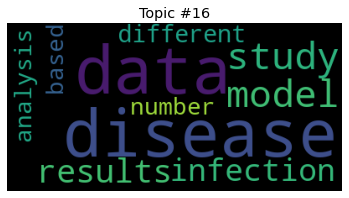

Number of topics: 1
(0, '0.009*"lung" + 0.006*"mice" + 0.005*"expression" + 0.004*"cells" + 0.004*"immune" + 0.004*"inflammatory" + 0.004*"virus" + 0.003*"infection" + 0.003*"levels" + 0.003*"acute" + 0.003*"role" + 0.003*"pulmonary" + 0.003*"respiratory" + 0.003*"cell" + 0.002*"ace2" + 0.002*"human" + 0.002*"patients" + 0.002*"increased" + 0.002*"viral" + 0.002*"disease"')


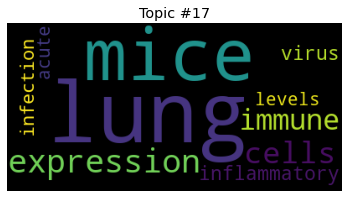

Number of topics: 1
(0, '0.017*"cats" + 0.011*"feline" + 0.005*"infection" + 0.005*"cat" + 0.005*"fip" + 0.004*"virus" + 0.004*"clinical" + 0.003*"fcov" + 0.003*"infectious" + 0.003*"fipv" + 0.003*"type" + 0.003*"coronavirus" + 0.003*"disease" + 0.003*"cats." + 0.003*"viral" + 0.003*"samples" + 0.003*"blood" + 0.003*"peritonitis" + 0.002*"study" + 0.002*"cats,"')


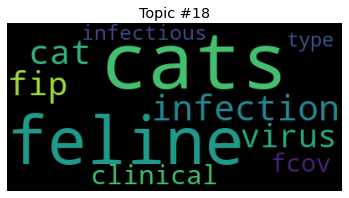

Number of topics: 1
(0, '0.016*"dogs" + 0.015*"canine" + 0.004*"rabies" + 0.004*"dog" + 0.004*"samples" + 0.003*"virus" + 0.003*"clinical" + 0.003*"fecal" + 0.003*"results" + 0.003*"infection" + 0.003*"analysis" + 0.003*"parvovirus" + 0.003*"study" + 0.003*"type" + 0.003*"disease" + 0.003*"detected" + 0.003*"strains" + 0.003*"coronavirus" + 0.003*"dogs." + 0.002*"pcr"')


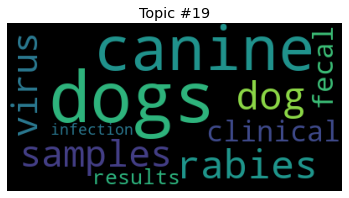

Number of topics: 1
(0, '0.006*"cells" + 0.006*"myelin" + 0.005*"virus" + 0.005*"viral" + 0.005*"demyelination" + 0.005*"cns" + 0.005*"disease" + 0.005*"mice" + 0.004*"brain" + 0.004*"infection" + 0.004*"multiple" + 0.004*"nervous" + 0.003*"central" + 0.003*"demyelinating" + 0.003*"cell" + 0.003*"axonal" + 0.003*"system" + 0.003*"role" + 0.003*"chronic" + 0.003*"spinal"')


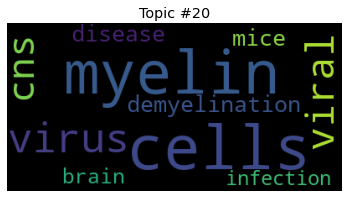

Number of topics: 1
(0, '0.009*"prrsv" + 0.007*"type" + 0.007*"virus" + 0.007*"ifn" + 0.006*"viral" + 0.006*"antiviral" + 0.005*"infection" + 0.005*"cells" + 0.005*"immune" + 0.004*"response" + 0.004*"signaling" + 0.004*"cell" + 0.004*"porcine" + 0.004*"interferon" + 0.004*"respiratory" + 0.003*"expression" + 0.003*"syndrome" + 0.003*"innate" + 0.003*"protein" + 0.003*"replication"')


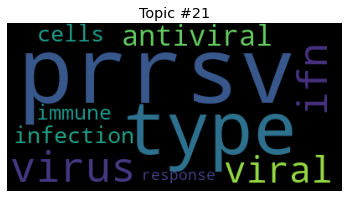

Number of topics: 1
(0, '0.027*"influenza" + 0.009*"virus" + 0.006*"respiratory" + 0.004*"patients" + 0.004*"pandemic" + 0.004*"infection" + 0.004*"viruses" + 0.003*"data" + 0.003*"study" + 0.003*"viral" + 0.003*"human" + 0.003*"h5n1" + 0.003*"surveillance" + 0.002*"avian" + 0.002*"ili" + 0.002*"severe" + 0.002*"health" + 0.002*"clinical" + 0.002*"associated" + 0.002*"positive"')


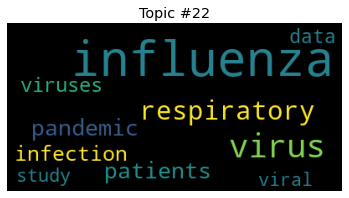

Number of topics: 1
(0, '0.021*"ibv" + 0.011*"virus" + 0.007*"infectious" + 0.007*"strains" + 0.006*"bronchitis" + 0.005*"vaccine" + 0.005*"gene" + 0.004*"isolates" + 0.004*"avian" + 0.004*"showed" + 0.004*"sequence" + 0.004*"strain" + 0.004*"viral" + 0.004*"chicken" + 0.004*"(ibv)" + 0.004*"results" + 0.003*"different" + 0.003*"sequences" + 0.003*"chickens" + 0.003*"respiratory"')


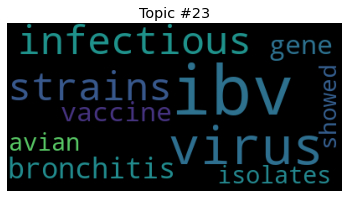

Number of topics: 1
(0, '0.005*"vaccine" + 0.004*"human" + 0.004*"immune" + 0.004*"virus" + 0.003*"development" + 0.003*"vaccines" + 0.003*"antibodies" + 0.003*"new" + 0.003*"viral" + 0.003*"disease" + 0.003*"clinical" + 0.002*"potential" + 0.002*"antibody" + 0.002*"protein" + 0.002*"including" + 0.002*"review" + 0.002*"different" + 0.002*"drug" + 0.002*"diseases" + 0.002*"studies"')


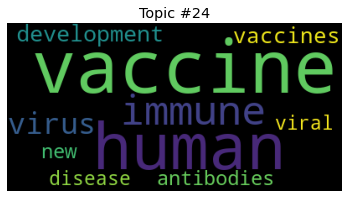

Number of topics: 1
(0, '0.010*"dengue" + 0.009*"virus" + 0.007*"zikv" + 0.005*"pdcov" + 0.004*"viral" + 0.004*"denv" + 0.004*"infection" + 0.003*"viruses" + 0.003*"protein" + 0.003*"study" + 0.003*"rna" + 0.003*"cells" + 0.002*"results" + 0.002*"zika" + 0.002*"antiviral" + 0.002*"identified" + 0.002*"health" + 0.002*"severe" + 0.002*"replication" + 0.002*"human"')


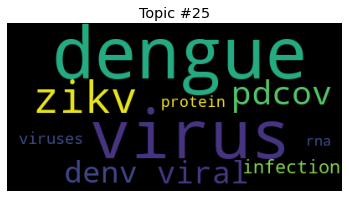

In [82]:
# convert the corpus into a sparse matrix format for gensim
for i in range(0,26):
    text_data = []
    for index, row in df[df['y']==i].iterrows():
        abstract_text = prepare_text_for_lda(row['abstract'])
        text_data.append(abstract_text)
            
    dictionary = corpora.Dictionary(text_data)
    corpus = [dictionary.doc2bow(text) for text in text_data]
    # train latent Dirichlet topic model
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = 1, id2word=dictionary, passes=30)
    topics = ldamodel.print_topics(num_topics = NUM_TOPICS, num_words=20)
    print ('Number of topics:', len(topics))
    for topic in topics:
        print(topic)
    lda_dict = dict(ldamodel.show_topic(0))
    plt.figure()
    plt.imshow(WordCloud().fit_words(lda_dict))
    plt.axis("off")
    plt.title("Topic #" + str(i))
    plt.savefig("Topic #"+ str(i) + " .png")
    plt.show()

# Saving the Clustering Result to a CSV file

In [92]:
df.to_csv("COVID-19 Literature Clustering Final Result.csv", index=False)

# Cluster Analysis

In [94]:
df[df['y']==11].loc[:,["title"]]

,title
19397,Adapting to a new normal? 5 key operational p...
4355,Neonatal COVID-19: little evidence and the ne...
14526,Operative team checklist for aerosol generati...
13766,The Wheezing Illnesses Study Leidsche Rijn (W...
24157,Use of ward closure to control outbreaks amon...
...,...
19009,Breast radiotherapy under COVID-19 pandemic r...
4914,Implications for COVID-19: a systematic revie...
14104,Patient factors that affect trust in physicia...
14134,Debate: Transfusing to normal haemoglobin lev...


In [96]:
df[df['y']==15].loc[:,["title"]]

,title
16481,Panther Fusion® Respiratory Virus Assays for ...
16913,Molecular detection and typing of human picor...
5456,Automated degenerate PCR primer design for hi...
7489,"Post-mortem diagnosis, of cytomegalovirus and..."
15039,Rapid detection and identification of 12 resp...
...,...
32067,Role of Molecular Diagnostics in the Manageme...
18016,Development and validation of a real-time PCR...
26419,Detection of Clostridium perfringens alpha to...
17325,Evaluation of a single-tube fluorogenic RT-PC...


In [98]:
df[df['y']==19].loc[:,["title"]]

,title
14086,Improvement in Clinical Symptoms and Fecal Mi...
21178,Partial DNA cloning and sequencing of a canin...
22505,Canine babesiosis among working dogs of organ...
24564,Renewed Global Partnerships and Redesigned Ro...
12099,High‐cell‐passage canine coronavirus vaccine ...
7049,Novel Norovirus in Dogs with Diarrhea
6865,Validation of a fecal scoring scale in puppie...
29328,Amelioration of oxidative stress using N‐acet...
17157,THORACIC RADIOGRAPHIC CHARACTERISTICS OF CANI...
18908,Rapid and sensitive detection of canine diste...


In [100]:
df[df['y']==25].loc[:,["title"]]

,title
14053,Dengue virus compartmentalization during anti...
25867,"Interrelationship between Climatic, Ecologic,..."
30530,Development of Antibody Therapeutics against ...
4616,Evaluation of antiviral activities of Houttuy...
24814,The molecular tweezer CLR01 inhibits Ebola an...
21241,Unusual and rare manifestations of dengue dur...
19872,IFITM Proteins Restrict Antibody-Dependent En...
16226,Development of an indirect ELISA for detectin...
3655,Describing dengue epidemics: Insights from si...
25126,Treatment of AG129 mice with antisense morpho...
